/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6843 - loss: 1.8849 - precision: 0.6569 - recall: 0.7212
Epoch 1: val_accuracy improved from -inf to 0.82584, saving model to /kaggle/working/best_model_resnet.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 903ms/step - accuracy: 0.6884 - loss: 1.8481 - precision: 0.6619 - recall: 0.7248 - val_accuracy: 0.8258 - val_loss: 0.3796 - val_precision: 0.9130 - val_recall: 0.7159 - learning_rate: 0.0010
Epoch 2/50
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9152 - loss: 0.2371 - precision: 0.9304 - recall: 0.9073
Epoch 2: val_accuracy improved from 0.82584 to 0.86517, saving model to /kaggle/working/best_model_resnet.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.9149 - loss: 0.2350 - precision: 0.9288 - recall: 0.9078 - val_accuracy: 0.8652 - val_loss: 0.2599 - val_precision: 0.9000 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 3/50
22/23 ━━━━━━━━━━━━━━━━━━

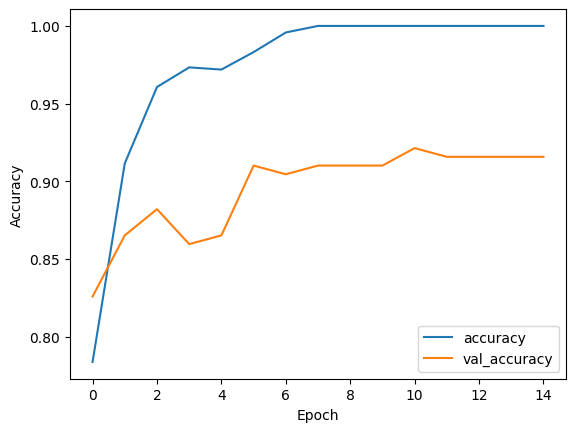

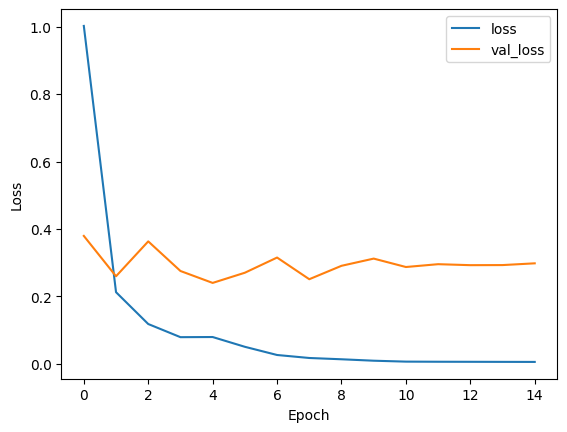

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Dropout, BatchNormalization, Flatten, MaxPool2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB2
from tensorflow.keras import layers
from tensorflow.keras import Model

# Load data
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['CANCER', 'NON CANCER']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/content/drive/MyDrive/oral dataset"
images, labels = load_data(folder_path)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# Define and compile the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the ResNet-50 base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_resnet50.compile(loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()], optimizer='adam')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = '/kaggle/working/best_model_resnet.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

# Train the model
history = model_resnet50.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Predict on new images
def predict_image(image_path, model):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Normalize the image if needed (e.g., if you are using a pre-trained model like ResNet50)
    image_array = image_array / 255.0

    # Make prediction
    prediction = model.predict(image_array)

    # Return the predicted class (0 for non-cancer, 1 for cancer)
    return 'Cancer' if prediction[0] > 0.5 else 'Non-cancer'

# Example usage: Predict on a new image


In [ ]:
image_path = '/content/drive/MyDrive/467.jpeg'  # Replace with the path to the new image
prediction = predict_image(image_path, model_resnet50)
print(f'The predicted class is: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
The predicted class is: Non-cancer
